In [385]:
import pandas as pd
import numpy as np
import os 
import math

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib as mpl
import seaborn as sns 

from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, mean_squared_error

In [386]:
from xgboost import XGBRegressor

In [387]:
RANDOM_SEED = 912

In [388]:
plot_params = {
    'font.family': 'Times',
    'font.weight': 'light',
    
    'figure.figsize': (15,15),
    'figure.frameon': False, 
    'figure.titlesize': 'xx-large',
    'figure.titleweight': 'normal',
    
    'axes.titlesize': 'x-large',
    'axes.titlecolor': 'black',
    'axes.titleweight': 'normal',
    'axes.titlelocation': 'center',
    'axes.labelsize': 'x-large',

    'grid.alpha': .25, 
    'legend.frameon':False,
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
}

pylab.rcParams.update(plot_params)
sns.set_palette('mako')

In [389]:
data_folder = 'data'
train_data_path = 'train.csv'
test_data_path = 'test.csv'
sample_submission_path = 'sample_submission.csv'

In [390]:
train_path = os.path.join(data_folder, train_data_path)
test_path = os.path.join(data_folder, test_data_path)
sample_path = os.path.join(data_folder, sample_submission_path)

In [391]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(sample_path)

In [392]:
# df_dtypes = train.dtypes.to_dict()
# for key, value in df_dtypes.items():
    
#     if df_dtypes[key] == 'float64':
#         df_dtypes[key] = 'float32'



In [393]:
# train = train.astype(df_dtypes)
# test = test.astype(df_dtypes.pop('cost'))

In [394]:
train.columns

Index(['id', 'store_sales(in millions)', 'unit_sales(in millions)',
       'total_children', 'num_children_at_home', 'avg_cars_at home(approx).1',
       'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case',
       'store_sqft', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food',
       'florist', 'cost'],
      dtype='object')

In [395]:
feature_columns = train.drop('cost', axis = 1).columns.tolist()
target_column = 'cost'

In [396]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          360336 non-null  int64  
 1   store_sales(in millions)    360336 non-null  float64
 2   unit_sales(in millions)     360336 non-null  float64
 3   total_children              360336 non-null  float64
 4   num_children_at_home        360336 non-null  float64
 5   avg_cars_at home(approx).1  360336 non-null  float64
 6   gross_weight                360336 non-null  float64
 7   recyclable_package          360336 non-null  float64
 8   low_fat                     360336 non-null  float64
 9   units_per_case              360336 non-null  float64
 10  store_sqft                  360336 non-null  float64
 11  coffee_bar                  360336 non-null  float64
 12  video_store                 360336 non-null  float64
 13  salad_bar     

In [397]:
train[feature_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
id,360336.0,180167.500000,104020.187637,0.00,90083.75,180167.50,270251.25,360335.00
store_sales(in millions),360336.0,6.337376,3.307980,0.51,3.72,5.78,8.40,22.92
unit_sales(in millions),360336.0,3.043881,0.784676,1.00,3.00,3.00,4.00,6.00
total_children,360336.0,2.456482,1.488992,0.00,1.00,2.00,4.00,5.00
num_children_at_home,360336.0,0.689390,1.214732,0.00,0.00,0.00,1.00,5.00
avg_cars_at home(approx).1,360336.0,2.203813,1.084293,0.00,1.00,2.00,3.00,4.00
gross_weight,360336.0,13.822071,4.614792,6.00,9.71,13.60,17.70,21.90
recyclable_package,360336.0,0.568086,0.495343,0.00,0.00,1.00,1.00,1.00
low_fat,360336.0,0.327797,0.469411,0.00,0.00,0.00,1.00,1.00
units_per_case,360336.0,18.972706,10.212912,1.00,10.00,20.00,28.00,36.00


In [398]:
train['id'].nunique()

360336

In [399]:
train.__len__()

360336

In [400]:
assert train['id'].nunique() == train.__len__()

In [401]:
feature_columns.remove('id')

In [402]:
unique_counts = train[feature_columns].nunique()
# binary_features =  [feature for feature, feature_unique_counts in zip(feature_columns, unique_counts) if unique_counts[feature] == 2]
binary_features = train.columns[train.isin([0,1]).all()].tolist()

In [403]:
binary_features

['recyclable_package',
 'low_fat',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist']

In [404]:
non_binary_features = list(set(feature_columns).difference(set(binary_features)))

In [405]:
train[non_binary_features].head(5)

,num_children_at_home,store_sqft,store_sales(in millions),avg_cars_at home(approx).1,gross_weight,total_children,units_per_case,unit_sales(in millions)
0,2.0,36509.0,8.61,2.0,10.30,2.0,32.0,3.0
1,0.0,28206.0,5.00,3.0,6.66,4.0,1.0,2.0
2,0.0,21215.0,14.08,3.0,21.30,0.0,26.0,4.0
3,0.0,21215.0,4.02,0.0,14.80,5.0,36.0,3.0
4,0.0,27694.0,2.13,3.0,17.00,5.0,20.0,3.0


In [406]:
continuous_features = ['store_sqft', 'store_sales(in millions)', 'gross_weight']


In [407]:
discrete_features = list(set(non_binary_features).difference(set(continuous_features)))
discrete_features

['num_children_at_home',
 'avg_cars_at home(approx).1',
 'total_children',
 'units_per_case',
 'unit_sales(in millions)']

In [408]:
assert len(feature_columns) == len(binary_features) \
                                + len(non_binary_features) 

In [409]:
assert len(feature_columns) == len(discrete_features) \
                                + len(continuous_features) \
                                + len(binary_features)

In [410]:
train.loc[:, binary_features] = train.loc[:, binary_features].astype('int16')

/var/folders/c6/5pqpts4j0z714gbd4lgp_1g80000gn/T/ipykernel_56134/3210219433.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train.loc[:, binary_features] = train.loc[:, binary_features].astype('int16')


In [411]:
# fig, axs = plt.subplots(ncols=1, nrows=len(binary_features), figsize = (5,25), sharey=True)
# axs = axs.flatten()
# train_len = train.__len__()
# for col, ax in zip(binary_features, axs):
#     norm_value_counts = train[col].value_counts() / train_len
#     sns.barplot(x = norm_value_counts.index,y = norm_value_counts.values, ax = ax, palette='hls').set_title(col)
#     ax.grid(.25, axis = 'y')
#     ax.set_frame_on(False)
# handles, labels = ax.get_legend_handles_labels()
# # fig.set_title("Feature columns wrt. the target values")
# fig.legend(handles, labels, loc = 'center right', prop = {'size': 20})
# fig.tight_layout()

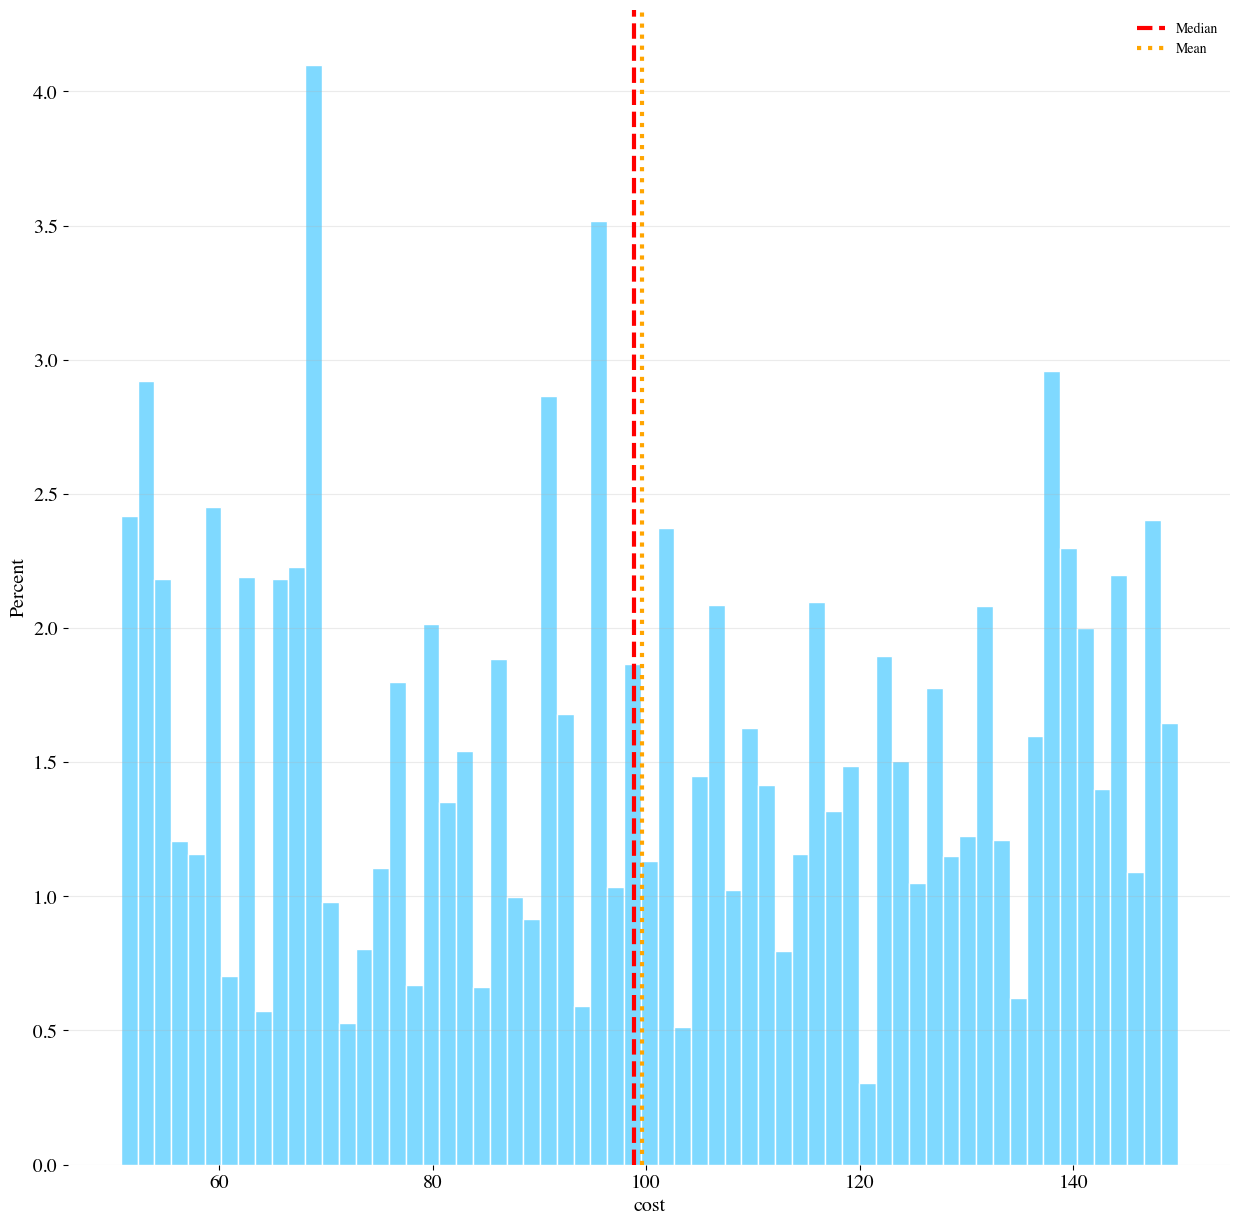

In [448]:
sns.histplot(train['cost'], stat = 'percent', edgecolor = 'white', color = sns.color_palette('hsv', 8)[4], alpha = .5)
plt.axvline(np.median(train['cost']), color = 'red', linestyle = '--', label = 'Median', linewidth = 3)
plt.axvline(np.mean(train['cost']), color = 'orange', linestyle = ':', label = 'Mean', linewidth = 3)
plt.legend()
plt.grid(.25, axis = 'y')
plt.box(False)

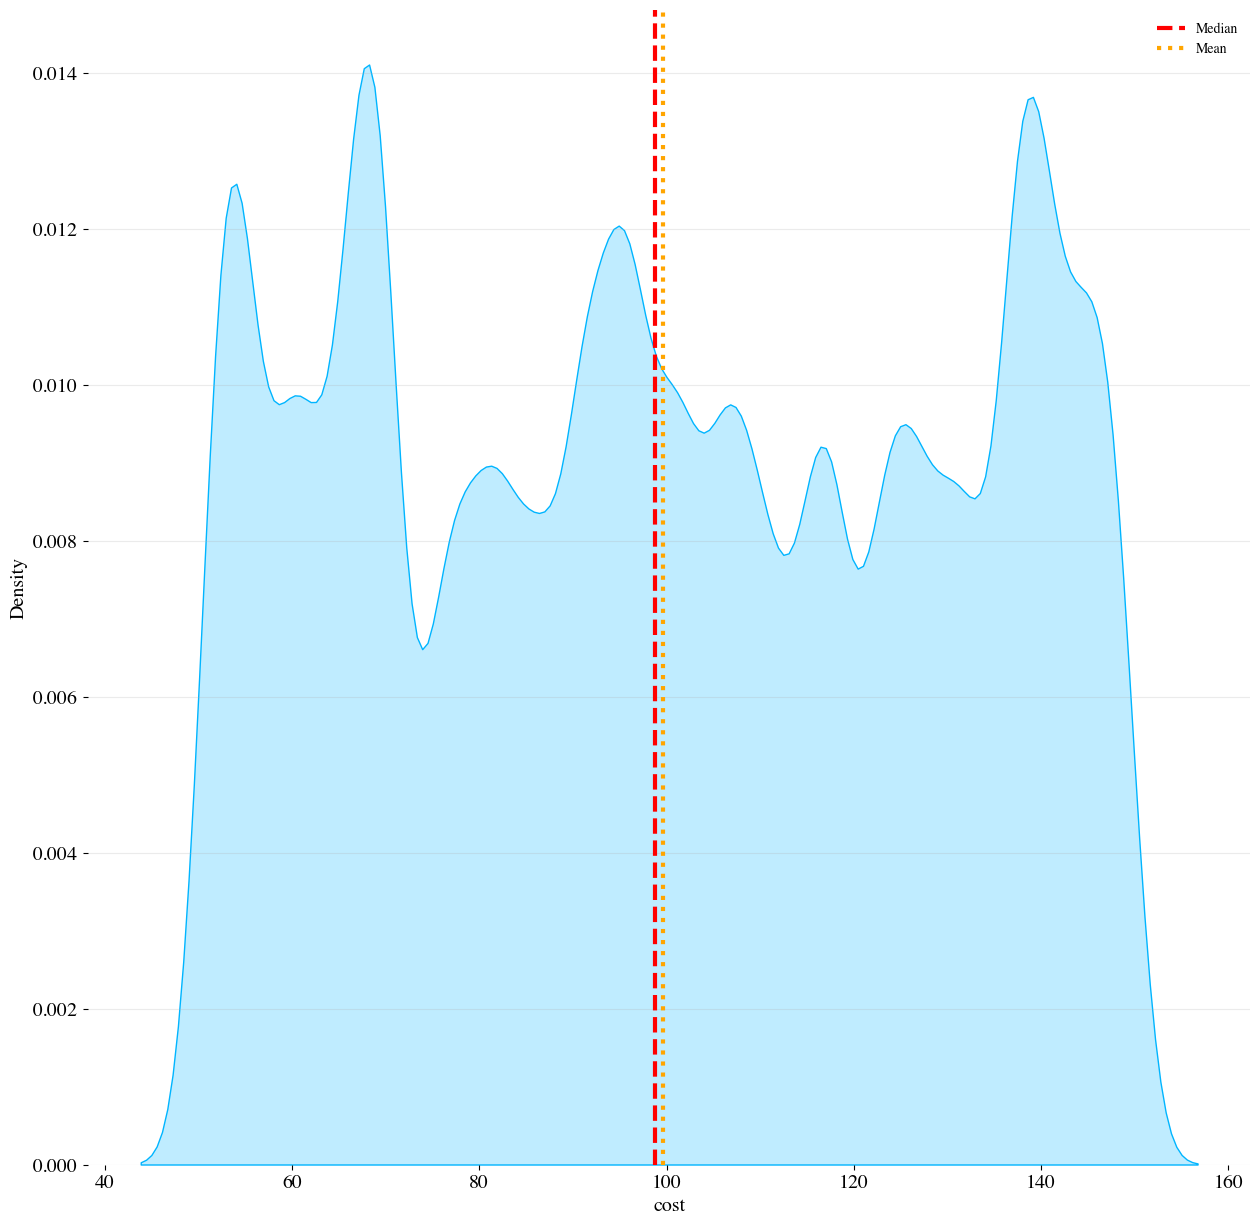

In [446]:
sns.kdeplot(train['cost'], fill = True, color = sns.color_palette('hsv', 8)[4],)
plt.axvline(np.median(train['cost']), color = 'red', linestyle = '--', label = 'Median', linewidth = 3)
plt.axvline(np.mean(train['cost']), color = 'orange', linestyle = ':', label = 'Mean', linewidth = 3)
plt.legend()
plt.grid(.25, axis = 'y')
plt.box(False)

In [412]:
binary_value_counts = train.loc[:, binary_features].apply(pd.value_counts).T / train.__len__()

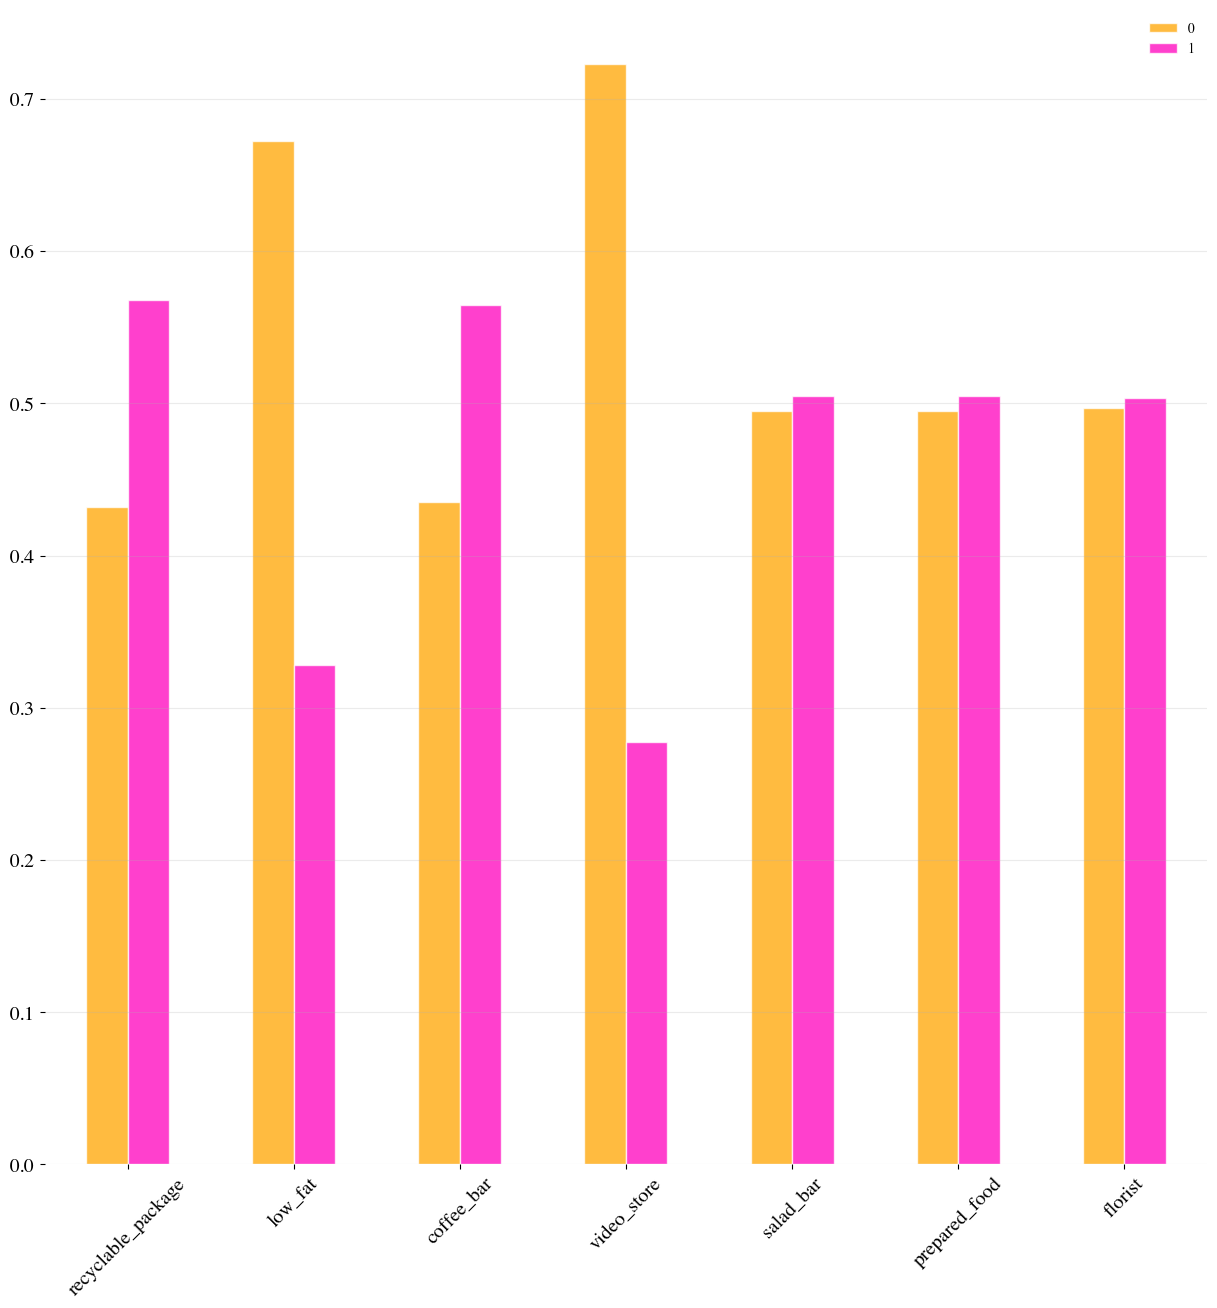

In [413]:
binary_value_counts.plot.bar(cmap = mpl.colors.ListedColormap(sns.color_palette('hsv', 8)), alpha = .75, edgecolor = 'white')
plt.grid(0.25, axis = 'y')
plt.box(False)
plt.xticks(rotation = 45)
plt.show()

In [414]:
binary_value_counts['differences'] = binary_value_counts[0] - binary_value_counts[1]

In [415]:
binary_value_counts

,0,1,differences
recyclable_package,0.431914,0.568086,-0.136173
low_fat,0.672203,0.327797,0.344406
coffee_bar,0.435161,0.564839,-0.129679
video_store,0.722606,0.277394,0.445212
salad_bar,0.495193,0.504807,-0.009613
prepared_food,0.495168,0.504832,-0.009663
florist,0.496809,0.503191,-0.006383


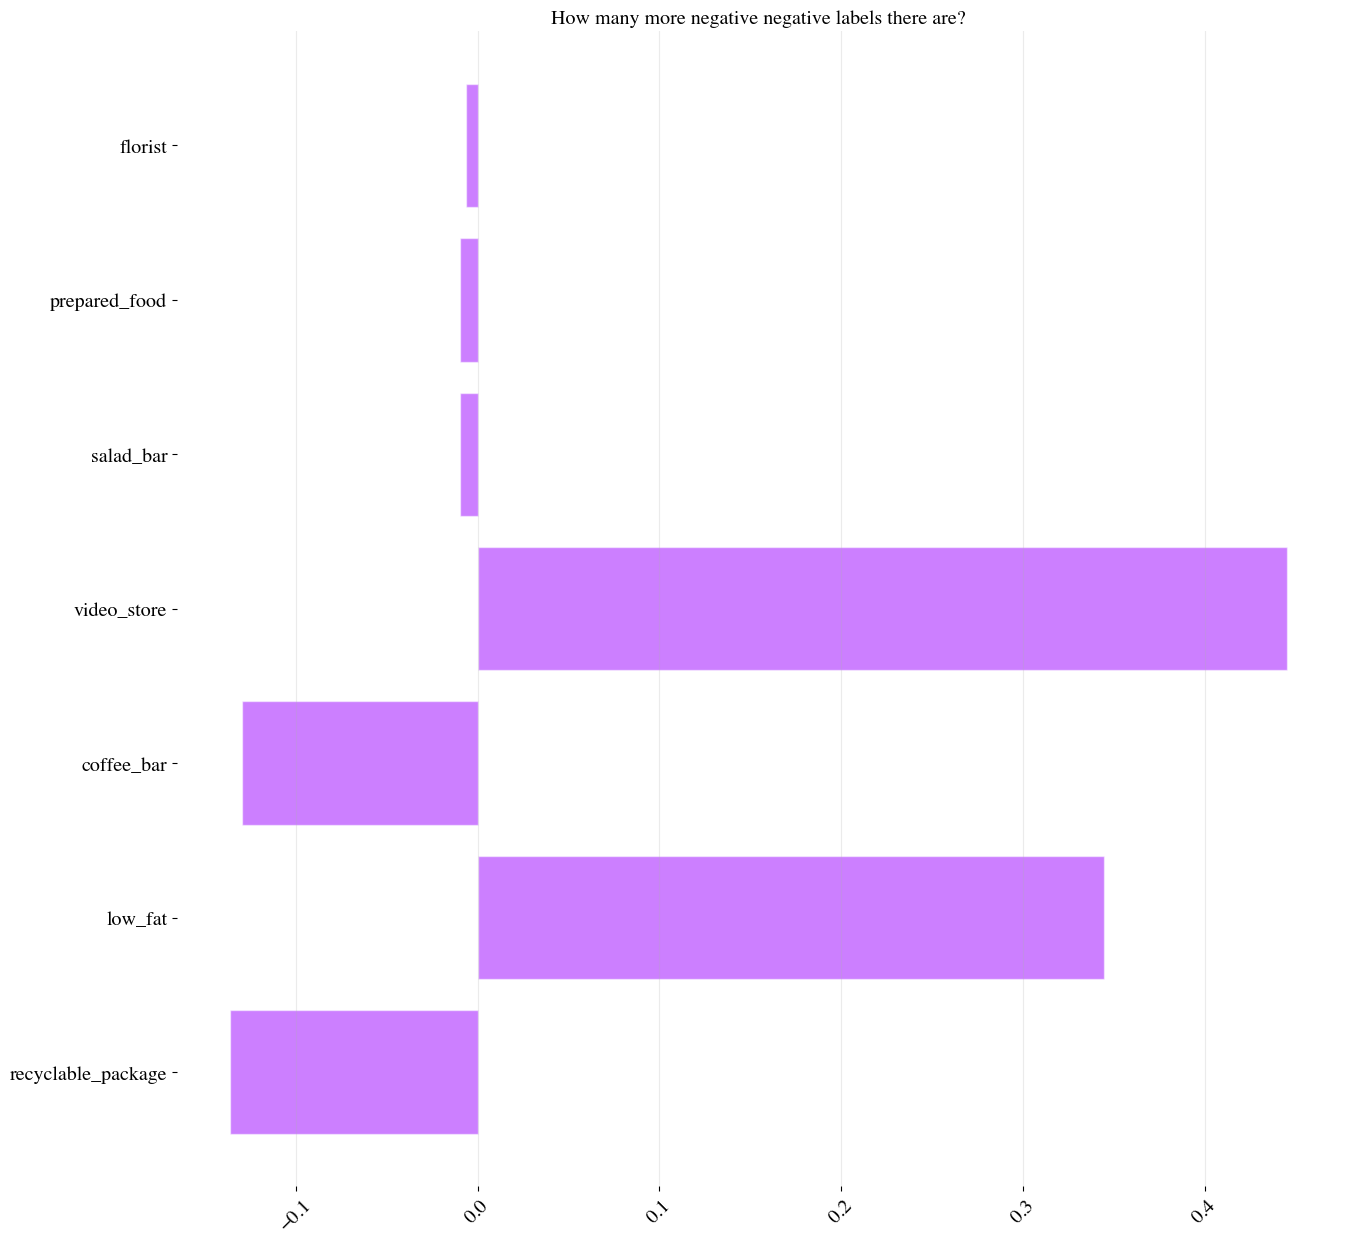

In [416]:
plt.barh(binary_value_counts.differences.index, binary_value_counts.differences.values, color = sns.color_palette('hsv', 8)[6], alpha = .5, edgecolor = 'white')
plt.title("How many more negative negative labels there are?")
plt.grid(0.25, axis = 'x')
plt.box(False)
plt.xticks(rotation = 45)
plt.show()

In [417]:
train[discrete_features]

,num_children_at_home,avg_cars_at home(approx).1,total_children,units_per_case,unit_sales(in millions)
0,2.0,2.0,2.0,32.0,3.0
1,0.0,3.0,4.0,1.0,2.0
2,0.0,3.0,0.0,26.0,4.0
3,0.0,0.0,5.0,36.0,3.0
4,0.0,3.0,5.0,20.0,3.0
...,...,...,...,...,...
360331,5.0,3.0,5.0,33.0,4.0
360332,0.0,4.0,4.0,18.0,4.0
360333,0.0,2.0,0.0,35.0,3.0
360334,0.0,3.0,1.0,14.0,3.0


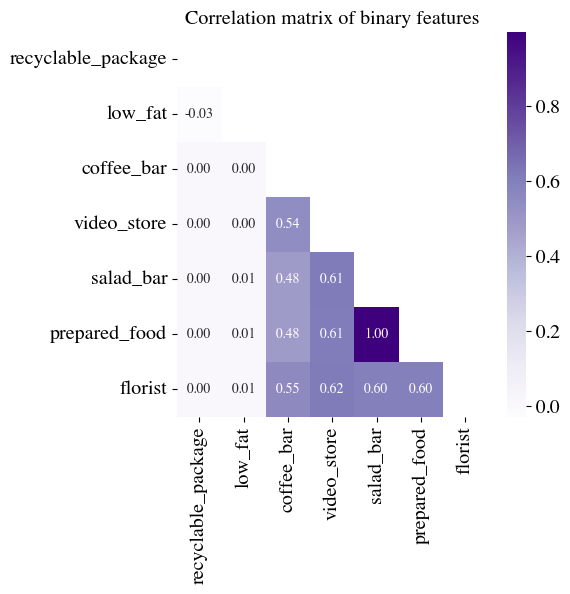

In [418]:
fig = plt.figure(figsize=(5,5))
corr_matrix = train[binary_features].corr()
upper_triangle = np.triu(corr_matrix)
sns.heatmap(corr_matrix, mask = upper_triangle, annot = True, fmt = '.2f', cmap='Purples').set_title('Correlation matrix of binary features')
plt.show()

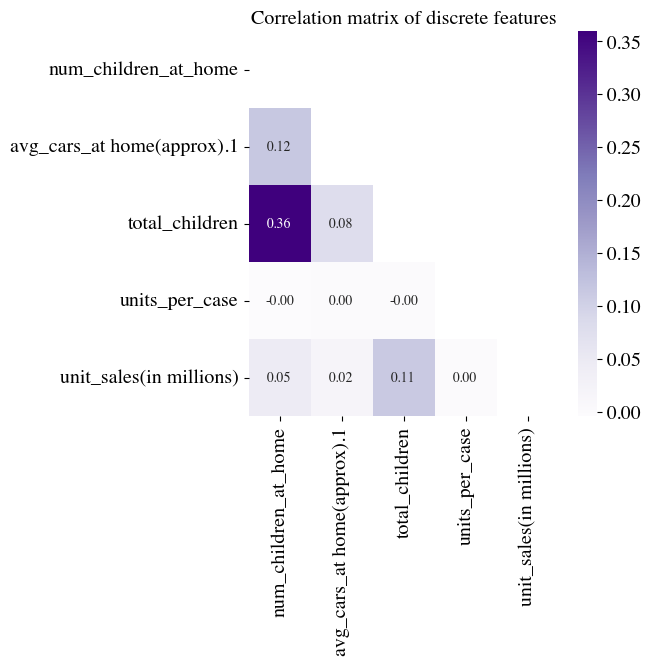

In [419]:
fig = plt.figure(figsize=(5,5))
corr_matrix = train[discrete_features].corr()
upper_triangle = np.triu(corr_matrix)
sns.heatmap(corr_matrix, mask = upper_triangle, annot = True, fmt = '.2f', cmap='Purples').set_title('Correlation matrix of discrete features')
plt.show()

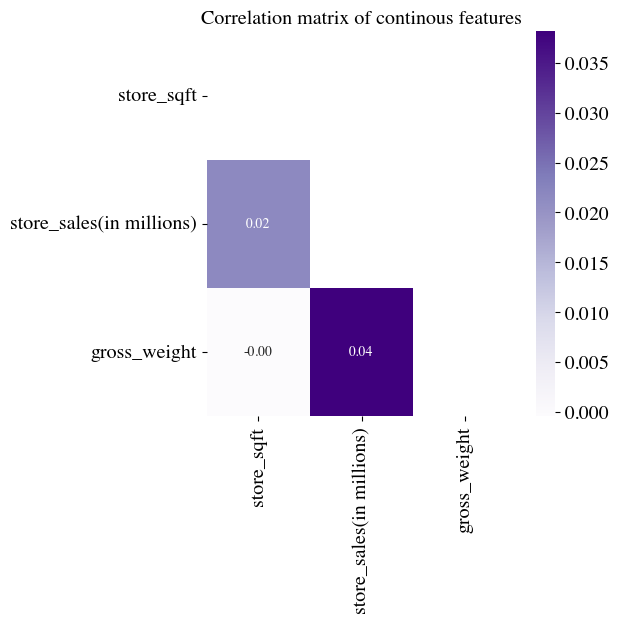

In [420]:
fig = plt.figure(figsize=(5,5))
corr_matrix = train[continuous_features].corr()
upper_triangle = np.triu(corr_matrix)
sns.heatmap(corr_matrix, mask = upper_triangle, annot = True, fmt = '.2f', cmap='Purples').set_title('Correlation matrix of continous features')
plt.show()

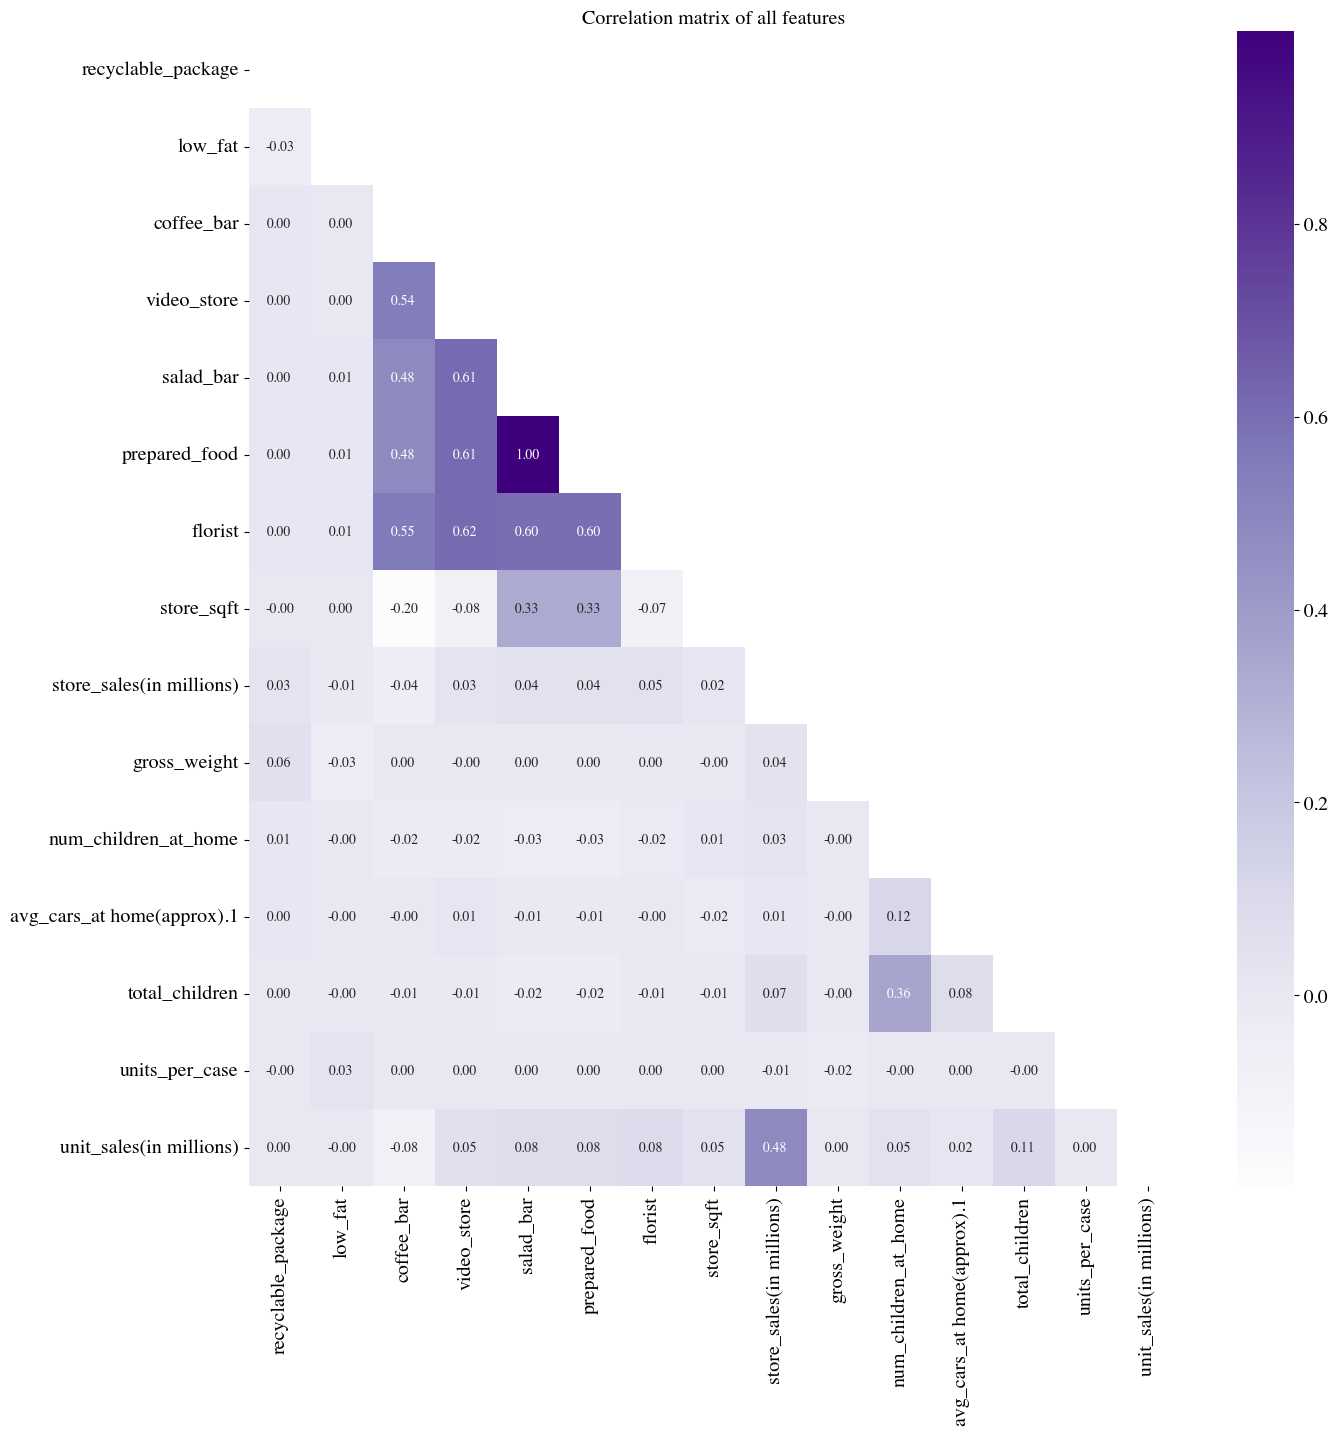

In [421]:
fig = plt.figure(figsize=(15,15))
corr_matrix = train.loc[:, binary_features + continuous_features + discrete_features].corr()
upper_triangle = np.triu(corr_matrix)
sns.heatmap(corr_matrix, mask = upper_triangle, annot = True, fmt = '.2f', cmap='Purples').set_title('Correlation matrix of all features')
plt.show()

In [51]:
x, y = train.drop('cost', axis = 1), train.cost

In [52]:
cv = KFold(n_splits=3, random_state=RANDOM_SEED, shuffle=True)

In [53]:

metrics = []
for fold_idx, (train_idxs, test_idxs) in enumerate(cv.split(x, y)):
    x_train, x_valid = x.loc[train_idxs], x.loc[test_idxs]
    y_train, y_valid = y.loc[train_idxs], y.loc[test_idxs]

    model = XGBRegressor()
    model.fit(x_train, y_train)

    y_preds = model.predict(x_valid)
    rmsle = math.sqrt(mean_squared_log_error(y_valid, y_preds))
    mse = mean_squared_error(y_valid, y_preds)
    mae = mean_absolute_error(y_valid, y_preds)

    print(f"\tFold {fold_idx + 1}: \n\t MSLE: {rmsle}\n\t MAE: {mae}\n\t MSE: {mse}")

	Fold 1: 
	 MSLE: 0.30346422425536007
	 MAE: 24.302091422420816
	 MSE: 809.7045852400846
	Fold 2: 
	 MSLE: 0.30335034670049615
	 MAE: 24.187947287946336
	 MSE: 804.4396178605376
	Fold 3: 
	 MSLE: 0.30405574809682023
	 MAE: 24.315391763829666
	 MSE: 808.6775566880287


In [54]:
preds = model.predict(test)

In [55]:
sample_submission['cost'] = preds

In [56]:
sample_submission.to_csv('baseline.csv', index=False)